In [1]:
import os
import sys
import json
import seaborn as sns
import numpy as np
import pandas as pd
from loguru import logger as log

In [2]:
# Custom packages
from dtw import *
from utils import convert_warp_path_to_timeseries
from plotting import create_graph

In [3]:
log.remove()
log.add(sys.stderr, level="DEBUG");

In [4]:
%load_ext autoreload
%autoreload 2

#### Define initial parameters

For example, if biostratigraphic data indicates that the age of oldest sediments in the core cannot exceed 245,000 years, set the `max_age` variable to 245. Similarly, set the `min_age` variable to the minimum age you expect the core top to be. For piston core from the ocean bottom, it is a good idea to set this to 0, but if data is available, such as for example the topmost 10k years are missing, this variable can be set to start at something else than 0. 

In [5]:
min_age = 0  # in kiloyears (kyrs) before present
max_age = 600 # in kiloyears (kyrs) before present
time_step = 5  # in kiloyears

#### Set parameters for the run

In [6]:
# 2nd run
# ref = "1100"
# ref_path = f'out_warping-paths/dist-vs-time_core_{ref}_d18O_pl_LR04stack.txt'
# ref_cols = ['time', 'value']
# names = ['1150']
# variables = ['d18O', 'aragonite']

# # # Validation
# ref = "LR04stack"
# ref_path = f'data/{ref}.csv'
# ref_cols = ['time', 'd18O']
# names = ['validate_LR04']
# variables = ['d18O']

### Find best distance: LR04stack vs M74/4-1100

##### Run parameters

In [7]:
ref = "LR04stack"
ref_path = f'../data/{ref}.csv'
ref_cols = ['time', 'd18O']
names = ['1100']
variables = ['d18O', 'aragonite']

##### Load target (reference) data and limit by `min_age` and `max_age`

In [8]:
target = pd.read_csv(ref_path, usecols=ref_cols) 
target = target[target['time'] <= max_age]
target = target[target['time'] >= min_age]

In [9]:
target.head()

,time,d18O
0,0.0,3.23
1,1.0,3.23
2,2.0,3.18
3,3.0,3.29
4,4.0,3.30


##### Load unknown data

In [10]:
data = pd.read_csv(f'../data/core_1100_d18O_pl.csv', skip_blank_lines=True)

In [11]:
data.head()

,depth_m,d18O_pl
0,0.01,-1.924
1,0.06,-2.673
2,0.11,-2.551
3,0.16,-2.537
4,0.21,-2.290


##### Define DTW object

In [12]:
dtw = SedimentDTW(target=target['d18O'], 
                  data=data['d18O_pl'], 
                  normalize=True, 
                  smooth=True, 
                  window_size=11, 
                  polynomial=3)

2023-04-01 21:02:50.505 | DEBUG    | dtw:__init__:77 - Time-warp object created successfully!


##### Find simple distance

In [13]:
simple_distance = dtw.simple_distance()
print(round(simple_distance, 2))

12.2


##### Find minimum distance iteratively

In [14]:
distance, time, min_distances = dtw.find_min_distance(min_age, max_age, time_step)
print(f'Found minimum distance: {round(distance, 2)} at target time {time} kyrs')

Found minimum distance: 3.84 at target time 275 kyrs


Text(0, 0.5, 'Distance')

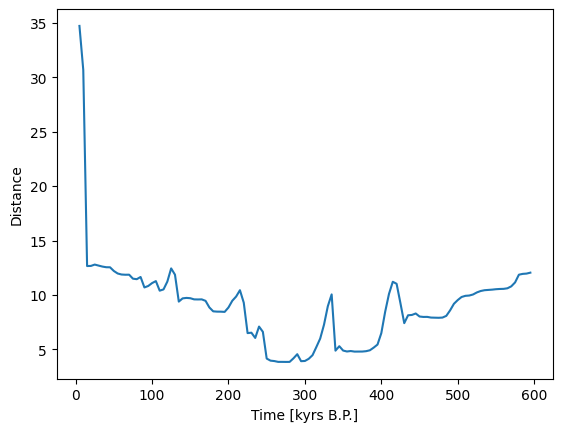

In [15]:
sns.lineplot(x=min_distances.keys(), y=min_distances.values(), data=min_distances)
plt.xlabel("Time [kyrs B.P.]")
plt.ylabel("Distance")

In [16]:
type(min_distances)

multiprocessing.managers.DictProxy